...welcome back!


#TITANIC Part II

##Machine Learning from Disaster: Introduction to Scikit-Learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.io.sql as pd_sql
import sqlite3 as sql

%matplotlib inline

In [4]:
# re-establish database connection
con = sql.connect("titanic.db") 

# extract everything from the 'training_data' table (or whatever you called it) into a dataframe
train = pd_sql.read_sql('select * from training_data', con, index_col='index')

In [5]:
#Is it all still here?
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
index,,,,,,,,,,,
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,None,S


### Creating a Model: A Naive Approach    

Let's start by creating a model that predicts purely based on gender

In [6]:
# Set some variables
number_passengers = train.shape[0] 
number_survived = len(train[train.Survived == 1])

# What proportion of the passengers survived?
proportion_survived = float(number_survived) / number_passengers
print 'The proportion of passengers who survived is %s.' % proportion_survived

The proportion of passengers who survived is 0.383838383838.


In [7]:
# How can we determine what proportion of the women and of the men who survived?
# Let's start by segregating the men and women
women = train[train.Sex == "female"]
men = train[train.Sex != "female"]

# Determine the proportion of women who survived
proportion_women_survived = float(len(women[women.Survived == 1])) / len(women)
print 'The proportion of women who survived is %s.' % proportion_women_survived

# Determine the proportion of men who survived
proportion_men_survived = float(len(men[men.Survived == 1])) / len(men)
print 'The proportion of men who survived is %s.' % proportion_men_survived

The proportion of women who survived is 0.742038216561.
The proportion of men who survived is 0.188908145581.


So we know that women were MUCH more likely to survive, and we could just say that our model is:
- if female => survived = 1
- if male => survived = 0

But that means our predictions are going to be wrong sometimes -- for about a quarter of the women and a fifth of the men. Let's use the Python library Scikit-learn to see if we can do a little better!

## Using Scikit-learn

Scikit-Learn is a powerful machine learning library implemented in Python with numeric and scientific computing powerhouses Numpy, Scipy, and matplotlib for extremely fast analysis of small to medium-sized data sets. It is open source, commercially usable and contains many modern machine learning algorithms for classification, regression, clustering, feature extraction, and optimization. For this reason Scikit-Learn is often the first tool in a data scientist's toolkit for machine learning of incoming data sets.

Scikit-learn will expect numeric values and no blanks, so first we need to do a bit more wrangling.

In [8]:
# 'Sex' is stored as a text value. We should convert (or 'map') it into numeric binaries 
# so it will be ready for scikit-learn.
train['Sex'] = train['Sex'].map({'male': 0,'female': 1})

In [9]:
# Scikit-learn won't be tolerant of the missing values. In the last class, we dropped
# the 'Ticket' column. Let's also drop the 'Cabin' and 'Embarked' columns
train = train.drop(['Cabin'], axis=1)
train = train.drop(['Embarked'], axis=1)

In [10]:
# Let's also drop the 'Name' column for now (though I can think of some interesting 
# data that might be embedded in those salutations...)
train = train.drop(['Name'], axis=1)

Ok, we've got a table of purely numeric data with no null values. We're ready to go.

### LOGISTIC REGRESSION

A logistic regression mathematically calculates the decision boundary between the possibilities. It looks for a straight line that represents a cutoff that most accurately represents the training data.

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
# Load the test data
test = pd.read_csv("../titanic/data/test.csv") 
test["Age"] = test["Age"].fillna(train["Age"].median())

test.loc[test["Sex"] == "male", "Sex"] = 0
test.loc[test["Sex"] == "female", "Sex"] = 1

test = test.drop(['Cabin'], axis=1)
test = test.drop(['Embarked'], axis=1)
test = test.drop(['Name'], axis=1)
test = test.drop(['Ticket'], axis=1)

In [13]:
# Initialize our algorithm
lr = LogisticRegression(random_state=1)

In [14]:
# Define our predictors
predictors = ["Pclass", "Sex", "Age", "SibSp"]
expected  = train["Survived"]

# Train the algorithm using all the training data
lr.fit(train[predictors], expected)

# Make predictions using the training set -- where we already know the correct answers
predicted = lr.predict(train[predictors])

In [15]:
# Make predictions based on the test data
predictions = lr.predict(test[predictors])

# Frame your submission for Kaggle
test_predictions = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
test_predictions.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


Well that was easy! But how can we find out how well it worked?

### Cross-Validation   

For Kaggle, the training samples are constructed by splitting our original dataset into more than one part. But what if certain chunks of our data have more variance than others? We want to ensure that our model performs just as well regardless of the particular way the data are divided up. So let's go back and do some cross-validation splits.    

More on cross-validation tools inside Scikit-learn here:    
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html

In [16]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

In [17]:
X = train[["Pclass", "Sex", "Age", "SibSp"]]
y = train["Survived"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2)
log_reg = lr.fit(X_train, y_train)

In [18]:
# Every estimator has a score method that can judge the quality of the 
# fit (or the prediction) on new data. Bigger is better.   
log_reg.score(X_test, y_test)

0.82681564245810057

We can also ask for a classification report.

In [19]:
from sklearn.metrics import classification_report

In [20]:
expected   = y_test
predicted  = log_reg.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Perished","Survived"])
print classificationReport

             precision    recall  f1-score   support

   Perished       0.83      0.90      0.86       106
   Survived       0.83      0.73      0.77        73

avg / total       0.83      0.83      0.82       179



How do I interpret this report?
    
Precision is the number of correct positive results divided by the number of all positive results (e.g. how many of the passengers we predicted would survive actually did survive?).

Recall is the number of correct positive results divided by the number of positive results that should have been returned (e.g. how many of the passengers who did survive did we accurately predict would survive?). 

The F1 score is a measure of a test's accuracy. It considers both the precision and the recall of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.    

    precision = true positives / (true positives + false positives)

    recall = true positives / (false negatives + true positives)

    F1 score = 2 * ((precision * recall) / (precision + recall))
    
So how well did our Logistic Regression Model do?    

In [21]:
# Make predictions based on the test data
predictions = log_reg.predict(test[predictors])

# Frame your 2nd submission to Kaggle
kgl_submission_lr = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
kgl_submission_lr.to_csv('lr_model.csv', index=False)

### RANDOM FOREST    

Some models will work better than others! Let's try another one.    

A random forest is a 'meta estimator'. It will fit a number of decision trees (we'll have to tell it how many) on various sub-samples of the dataset. Then it will use averaging to improve the predictive accuracy and control over-fitting.    

Read more about Random Forests here:    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# We'll select 50 trees and opt for 'out-of-bag' samples to estimate the generalization error.
rf = RandomForestClassifier(n_estimators=50, oob_score=True) 

In [24]:
# Next split up the data with the 'train test split' method in the Cross Validation module
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# ...and then run the 'fit' method to build a forest of trees
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [25]:
rf.score(X_test, y_test)

0.77094972067039103

In [26]:
expected   = y_test
predicted  = rf.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Perished","Survived"])
print classificationReport

             precision    recall  f1-score   support

   Perished       0.86      0.77      0.81       115
   Survived       0.65      0.77      0.71        64

avg / total       0.78      0.77      0.77       179



So how did we do with our Random Forest Classifier? Sometimes visualizations can
help us to interpret our results. Here is a function that will take our classification
report and create a color-coded heat map that tells us where our model is strong (deep
reds) and/or weak (lighter pinks).

In [27]:
def plot_classification_report(cr, title='Classification report', cmap=plt.cm.Reds):

    lines = cr.split('\n')
    classes = []
    plotMat = []

    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    fig, ax = plt.subplots(1)
    fig = plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    for c in range(len(plotMat)+1):
        for r in range(len(classes)):
            try:
                txt = plotMat[r][c]
                ax.text(c,r,plotMat[r][c],va='center',ha='center')
            except IndexError:
                pass
            
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

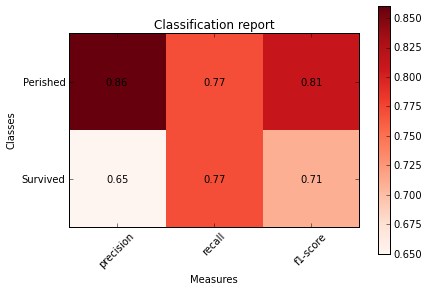

In [28]:
plot_classification_report(classificationReport)

In [29]:
# Make predictions based on the test data
predictions = rf.predict(test[predictors])

# Frame your 3rd submission to Kaggle
kgl_submission_rf = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
kgl_submission_rf.to_csv('rf_model.csv', index=False)

### SVM    

Support vector machines use points in transformed problem space to separate the classes into groups.

In [30]:
from sklearn.svm import SVC

In [31]:
kernels = ['linear', 'poly', 'rbf']

splits     = cross_validation.train_test_split(X,y, test_size=0.2)
X_train, X_test, y_train, y_test = splits

for kernel in kernels:
    if kernel != 'poly':
        model      = SVC(kernel=kernel)
    else:
        model      = SVC(kernel=kernel, degree=3)

model.fit(X_train, y_train)
expected   = y_test
predicted  = model.predict(X_test)

SVC_report = classification_report(expected, predicted)

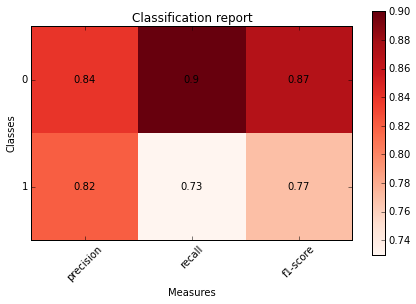

In [32]:
plot_classification_report(SVC_report)

<function matplotlib.pyplot.show>

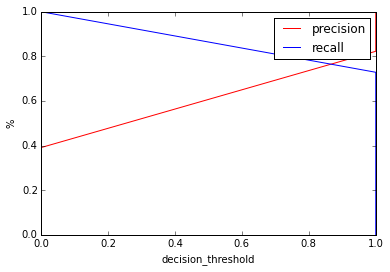

In [33]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predicted)  
decision_threshold = np.append(thresholds, 1)

plt.plot(decision_threshold, precision, color='red')  
plt.plot(decision_threshold, recall, color='blue')  
leg = plt.legend(('precision', 'recall'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('decision_threshold')  
plt.ylabel('%')  
plt.show

In [34]:
# Make predictions based on the test data
predictions = model.predict(test[predictors])

# Frame your 4th submission to Kaggle
kgl_submission_svm = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
kgl_submission_svm.to_csv('svm_model.csv', index=False)

So of the four methods - our naive model, as well as Logistic Regression, Random Forest, and SVM, which one performed the best on this data set?

### Resources and Further Reading    

This tutorial is based on the Kaggle Competition, "Predicting Survival Aboard the Titanic"    
https://www.kaggle.com/c/titanic    

As well as the following tutorials:    
https://www.kaggle.com/mlchang/titanic/logistic-model-using-scikit-learn/run/91385    
https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests    
https://github.com/savarin/pyconuk-introtutorial/tree/master/notebooks    

See also:    
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html    
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html    
http://scikit-learn.org/stable/modules/svm.html      